In [40]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

device = torch.device("mps")

In [166]:
# simple tokenization by characters

lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print(vocab)
print('vocab size:', len(vocab))

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab size: 65


In [167]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset

tensor([18, 47, 56,  ..., 45,  8,  0], dtype=torch.int8)

In [168]:
config = {
    "d_model": 100,
    "vocab_size": len(vocab),
    'batch_size': 32,
    'context_window': 10,
}


def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('\nPOMPEY:\nV', 'POMPEY:\nVe'),
 ('\n\nQUEEN MA', '\nQUEEN MAR'),
 ('hollow eye', 'ollow eyes'),
 ('hanging.\n\n', 'anging.\n\nP'),
 (' is that g', 'is that go'),
 (' he marrie', 'he married'),
 ('s one yond', ' one yonde'),
 ('spositions', 'positions '),
 ('fter holid', 'ter holida'),
 ("nd where's", "d where's "),
 ('ech you, t', 'ch you, ta'),
 ('Clown:\nCom', 'lown:\nCome'),
 ('n his cour', ' his cours'),
 (', defend m', ' defend me'),
 ('IUS:\nThe s', 'US:\nThe se'),
 ('ARD IV:\nBr', 'RD IV:\nBro'),
 ('rey\nWere f', 'ey\nWere fa'),
 ('progress t', 'rogress to'),
 ('its on the', 'ts on the '),
 ('\nTo think ', 'To think i'),
 (' mistake.\n', 'mistake.\n\n'),
 ('s raising;', ' raising;\n'),
 (' hear\nIs t', 'hear\nIs th'),
 ('\n\nFLORIZEL', '\nFLORIZEL:'),
 ('\nOf my boy', "Of my boy'"),
 ('nt.\nThe wr', 't.\nThe wre'),
 ('vault,\nTha', 'ault,\nThat'),
 ('RLAND:\nBe ', 'LAND:\nBe i'),
 ('ct,\nUnder ', 't,\nUnder w'),
 ('ure to die', 're to die.'),
 ('ce I will ', 'e I will r'),
 (

In [169]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [170]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [171]:
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.

        https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

tensor([1.4795, 1.2524, 1.1793, 1.1886, 0.9937, 0.9293, 0.8054, 0.7651, 0.6825,
        0.6113], grad_fn=<SumBackward1>)

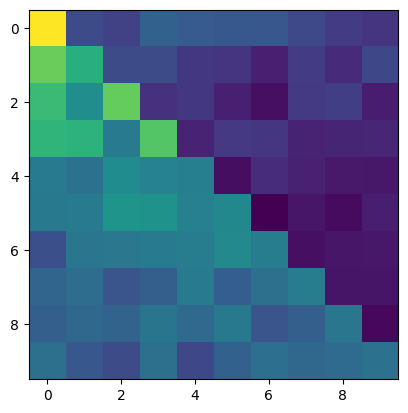

In [172]:
class LlamaAttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'])
        self.w_k = nn.Linear(config['d_model'], config['d_model'])
        self.w_v = nn.Linear(config['d_model'], config['d_model'])

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.rms = RMSNorm(config['d_model'])

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        activations, attn_weights = self.multihead(q,k,v, attn_mask=torch.tril(torch.ones(m,m)), is_causal=True)
        if return_attn_weights:
            return self.rms(x + activations), attn_weights
        return self.rms(x + activations) # TOOD: this is post-norm, try pre-norm

config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaAttentionLayer(config)
batch = torch.randn(1, 10, config['d_model'])
activations, attn_weights = m(batch, return_attn_weights=True)
plt.imshow(attn_weights.detach().numpy()[0])

attn_weights.squeeze(0).sum(dim=0)

In [173]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.attention = LlamaAttentionLayer(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )
        self.rms = RMSNorm(config['d_model'])
    
    def forward(self, x):
        attended = self.attention(x)
        out = self.rms(attended + self.feedforward(attended))
        return out
    
config = {
    "n_heads": 8,
    "d_model": 128,
}
m = LlamaBlock(config)
batch = torch.randn(1, 10, config['d_model'])
m(batch).shape

torch.Size([1, 10, 128])

In [205]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])

        self.positional_embeddings = nn.Embedding(config['context_window'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = x + self.positional_embeddings(torch.arange(x.shape[1]))
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
    def generate(self, idx, max_length=20):
        x = idx
        with torch.no_grad():
            for _ in range(max_length):
                sequence = x[:, -self.config['context_window']:]
                logits = self(sequence)[:,-1]
                probs = F.softmax(logits, dim=-1)
                pred = torch.multinomial(probs, 1, replacement=True)
                x = torch.cat([x, pred], dim=1)
            return x
            
config = {
    "n_heads": 1,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 1,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 50,
}
m = Llama(config)
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
m(xs, targets=ys)

print(f"n params: {sum([p.numel() for p in m.parameters() if p.requires_grad])}")

[decode(x) for x in m.generate(torch.zeros(5, 1).long()).tolist()]

n params: 233665


['\nuw\nitObmt?cIrSSh;U3A',
 '\n?pWozP-IJQe fAeBb.Wk',
 "\nzlCegw'Gm-P.tfAAjQ-V",
 '\nTtV\nUEp,NRGtLvDVs? n',
 '\n?zbMigBju$&VcHOvi QS']

In [206]:
config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 4,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 10000,
    "log_interval": 50,
}
model = Llama(config)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=1e-5)

losses = []
start_time = time.time()
for epoch in range(config['epochs']):
    optimizer.zero_grad()
    
    xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
    logits, loss = model(xs, targets=ys)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    if epoch % config['log_interval'] == 0:
        batch_time = time.time() - start_time
        x = evaluate_loss(model)
        losses += [x]
        print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
        start_time = time.time()

        print([decode(x) for x in m.generate(torch.zeros(5, 1).long()).tolist()])

pd.DataFrame(losses).plot()

Epoch 0 | val loss 4.169 | Time 0.043 | ETA in seconds 8.618
['\nZGxiVGHU?LSLLNJLx YM', "\n':FERPRU?'NFm,,x'Rvh", '\nbmo\nhTliERq,!RrzIaW!', "\nyeuhdSJA?ajC;g''obhU", '\nSSHAfcY,PCKr,-lMIwdf']
Epoch 50 | val loss 2.661 | Time 2.262 | ETA in seconds 450.152
["\n.Dt,gR3VXh'lTXvFB:Z,", '\n,fmfa-,dTbEJ\n-h3RRuk', '\nblsoMPrC&QVdKxLU?WGA', '\nB.Lj;WoFIquzz;EDIQib', "\nQ;MmCxh$-:'-P'qYRaYD"]
Epoch 100 | val loss 0.525 | Time 2.015 | ETA in seconds 399.045
['\nsR!jwnbUUiZrJ,SLB3ag', '\n,?:EFAcpUkVj$pWERO3T', '\n&cIIJzMyglL!JT,XosQ!', '\nDsFYwpvSQFcXa;OcIxC ', "\nm-awr.yP\naYqk'fMzbUq"]
Epoch 150 | val loss 0.197 | Time 1.954 | ETA in seconds 384.941
['\nbPouoVZUhbT iv!ZUvWy', '\n&Ok3gVsPUF&AeZXCW.hN', '\nGttbneyfC&fKpdnoqKjj', '\n:qYwM?yaloGAWZTus,Al', '\nTYJxcIn-M&&bnkbbK,!L']
Epoch 200 | val loss 0.179 | Time 1.965 | ETA in seconds 385.044
['\niP$UN-HTXcaa\nZbIq3xh', "\nEmJjL:cpv&IQl'MsBR.s", '\n3exKI!cmvgeK&n?iPcOH', '\n-.,P$Uuwo!nWkiOMjvfO', '\nXuqNLIrQruILRhI.-OMd']
Epoch 250 | val loss 

KeyboardInterrupt: 

In [209]:
def generate(model, idx, max_length=10):
    x = idx
    with torch.no_grad():
        for _ in range(max_length):
            sequence = x[:, -model.config['context_window']:]
            logits = model(sequence)[:,-1, :]
            probs = F.softmax(logits, dim=-1)
            pred = torch.multinomial(probs, 1, replacement=True)
            x = torch.cat([x, pred], dim=-1)
        return x

[decode(x) for x in generate(model, torch.randint(0, len(vocab), (5, 1)).long()).tolist()]

['KKKKKKKKKKK', 'TTTTTTTTTTT', 'ggggggggggg', 'HHHHHHGHHHH', 'IIIIIIIIIII']